In [33]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('../../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from LogisticRegression import LogisticRegression
from EmbEst import EmbEst
from NNEst import NNEst
from CNN import CNN
import similarities 
import DShap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
not_noise_idx = np.delete(np.arange(1000), noise_idx)
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv', data='../data/adult/')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

noise_labels = np.zeros(x_train.shape[0])
noise_labels[noise_idx] = 1.

In [35]:
model = NN(in_channels=108, out_channels=2, num_layers=1, hidden_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))
dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)

CEL = torch.nn.CrossEntropyLoss() 
print()

tic = time.time() 
run_id = dvgs.run(crit              = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), 
                  save_dir          = '../results/',
                  similarity        = similarities.cosine_similarity(),
                  optim             = torch.optim.Adam, 
                  lr                = 1e-3, 
                  num_epochs        = 100, 
                  compute_every     = 1, 
                  source_batch_size = 400, 
                  target_batch_size = 500,
                  num_workers       = 1, 
                  grad_params       = None, 
                  verbose           = True, 
                  use_cuda          = True)

vals_dvgs = dvgs.agg(f'../results/{run_id}/')
dvgs.clean(f'../results/{run_id}/')

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')


using device: cuda


KeyboardInterrupt: 

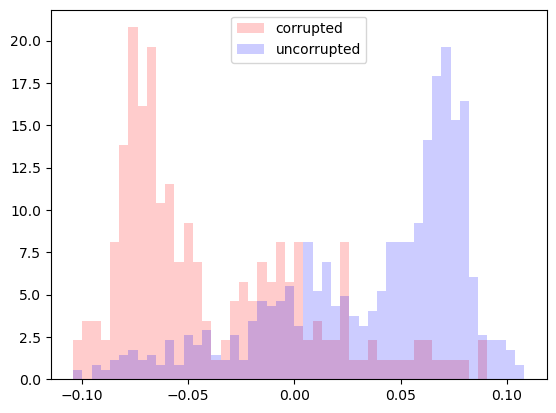

In [ ]:
plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)
plt.hist(vals_dvgs[noise_idx], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvgs[not_noise_idx], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

(1000,)


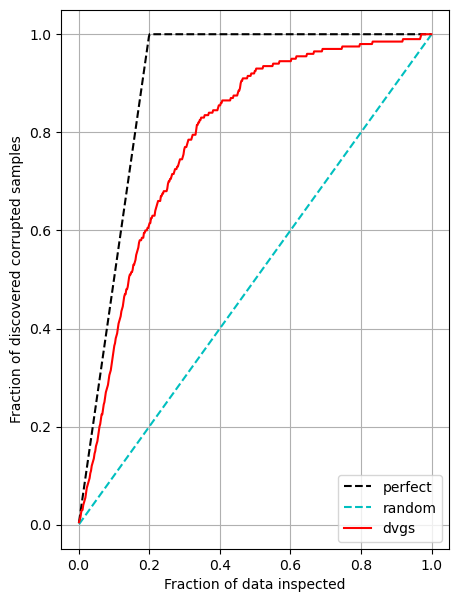

In [ ]:
pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs, noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [230]:
#pred = LogisticRegression(108, 2) 

pred = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.5, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))

# small lr 1e-4. entropy beta 1, lots of outer iterations 
#est = NN(in_channels=112, out_channels=1, num_layers=2, hidden_channels=100, norm=True, dropout=0., bias=True, act=torch.nn.Mish, out_fn=torch.nn.Sigmoid())
est = NNEst(xin=108, yin=4, y_cat_dim=100, out_channels=1, num_layers=4, hidden_channels=100, norm=True, dropout=0.0, bias=True, act=torch.nn.Mish)
#est = EmbEst(num_samples=x_train.shape[0])

dvrl = DVRL(x_train       = torch.tensor(x_train, dtype=torch.float), 
            y_train       = torch.tensor(y_train, dtype=torch.float).view(-1,1),
            x_valid       = torch.tensor(x_valid, dtype=torch.float), 
            y_valid       = torch.tensor(y_valid, dtype=torch.float).view(-1,1),
            predictor     = pred, 
            estimator     = est, 
            problem       = 'classification',
            include_marginal = False)

CEL = torch.nn.CrossEntropyLoss() 
print()

#dvrl.fit(dvrl.predictor, dvrl.x_train, dvrl.y_train, crit=lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), batch_size=256, lr=1e-4, epochs=500, use_cuda=True)


tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), 
                     outer_iter             = 1000, 
                     inner_iter             = 100, 
                     outer_batch            = 1000, 
                     inner_batch            = 250, 
                     estim_lr               = 1e-4, 
                     pred_lr                = 5e-4, 
                     moving_average_window  = 50,
                     entropy_beta           = 0.1, 
                     entropy_decay          = 0.999,
                     fix_baseline           = True,
                     noise_labels           = noise_labels,
                     use_cuda               = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      


pretraining `ori_model` and `val_model` 
outer iteration: 999 || reward: 0.0416 || dvrl perf: 0.8733 || baseline: 0.8317 || log entropy beta: -1.4345 || noise auc: 0.83|| epoch elapsed: 1e+00 ss
time elapsed: 14.54 min


In [172]:
#vals_dvrl = dvrl._predict_values(dvrl.x_train, dvrl.y_train)

In [231]:
vals_dvrl = vals_dvrl.detach().numpy().ravel()

In [232]:
vals_dvrl[0:5]

array([0.5806675 , 0.62402356, 0.49891025, 0.602809  , 0.6039732 ],
      dtype=float32)

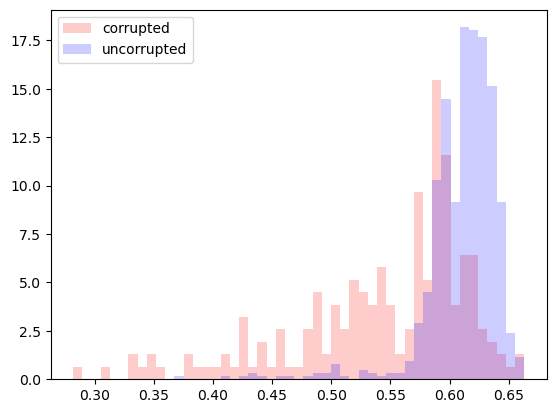

In [233]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[noise_idx], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[not_noise_idx], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

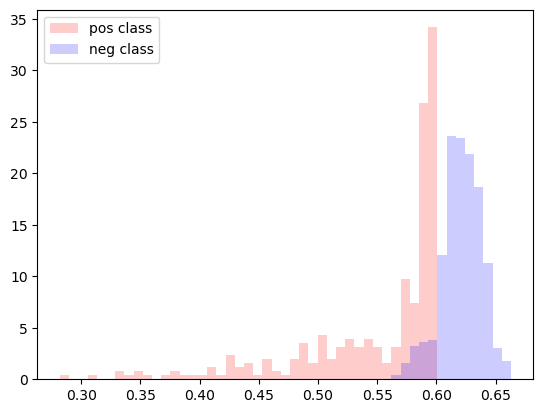

In [234]:
pos_class_idx = y_train.nonzero()
neg_class_idx = np.delete(np.arange(y_train.shape[0]), pos_class_idx)

plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[pos_class_idx], color='r', alpha=0.2, bins=bins, label='pos class', density=True)
plt.hist(vals_dvrl[neg_class_idx], color='b', alpha=0.2, bins=bins, label='neg class', density=True)
plt.legend()
plt.show()

(1000,)


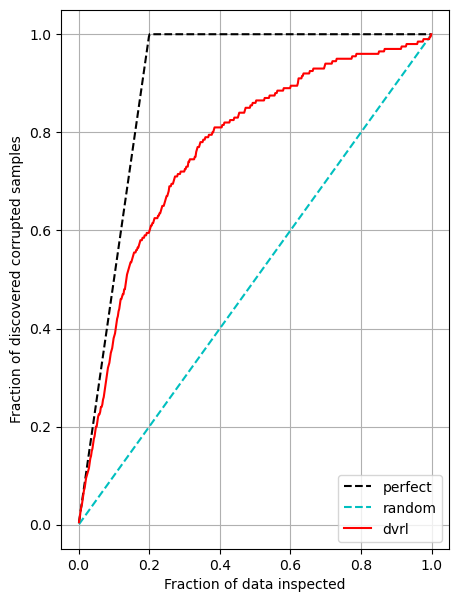

In [235]:
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(vals_dvrl, noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvrl_corr, 'r-', label='dvrl')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [ ]:
model = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = model.cpu(), 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    train_dataset   = copy.deepcopy(train_dataset), 
                    V               = DShap.V(copy.deepcopy(valid_dataset), roc_auc_score),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3)

tic = time.time() 
vals_shap = dshap.TMC(err=0.1, max_iterations=250, min_iterations=100, use_cuda=True, T=5, stopping_criteria=0.999)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

KeyboardInterrupt: 

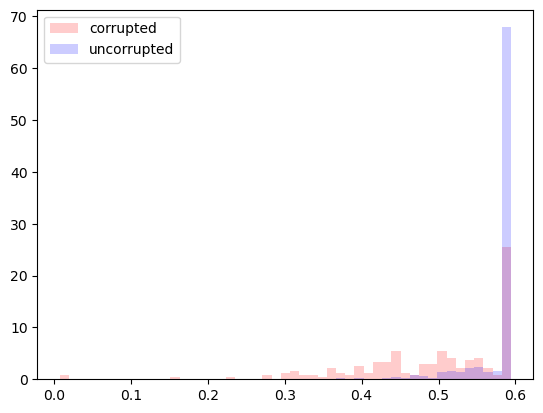

In [ ]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[noise_idx, 0].detach().cpu().numpy().ravel(), color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[not_noise_idx, 0].detach().cpu().numpy().ravel(), color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

In [ ]:
dvgs_data_values = vals_dvgs.mean(axis=1)
dvrl_data_values = vals_dvrl.detach().cpu().numpy().ravel() 
shap_data_values = vals_shap.ravel()

pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(dvgs_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(dvrl_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, shap_corr, p_perfect, p_random = get_corruption_scores(shap_data_values, noise_idx, train_size=1000, noise_prop=0.2)

(1000,)
(1000,)
(1000,)


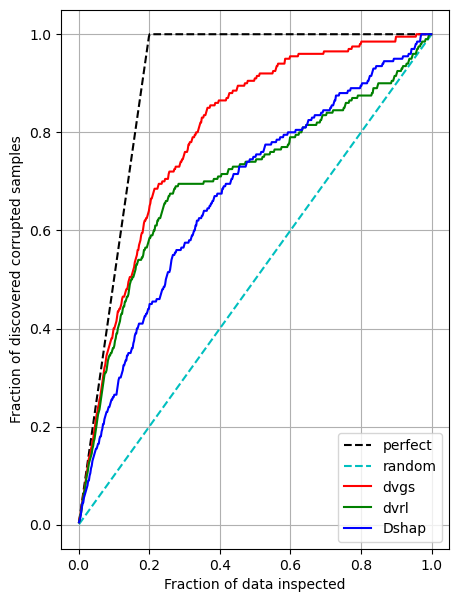

In [ ]:
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.plot(pk, dvrl_corr, 'g-', label='dvrl')
plt.plot(pk, shap_corr, 'b-', label='Dshap')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [ ]:
model = NN(in_channels=280, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.05, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long))
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1]) 

rand_data_values = np.random.normal(0,1,size=dvgs_data_values.shape)

qs = np.linspace(0., 0.5, 5)
bs = 256 
nw = 1 
lr = 1e-3 
ep = 100
rp = 3

dvgs_low, dvgs_high = get_filtered_scores(dvgs_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
dvrl_low, dvrl_high = get_filtered_scores(dvrl_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
shap_low, shap_high = get_filtered_scores(shap_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
rand_low, rand_high = get_filtered_scores(rand_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)


In [ ]:
plt.figure()
plt.plot(qs, dvgs_low, 'r-', label='dvgs-low')
plt.plot(qs, dvgs_high, 'r--', label='dvgs-high')

plt.plot(qs, dvrl_low, 'g-', label='dvrl-low')
plt.plot(qs, dvrl_high, 'g--', label='dvrl-high')

plt.plot(qs, shap_low, 'b-', label='shap-low')
plt.plot(qs, shap_high, 'b--', label='shap-high')

plt.plot(qs, rand_low, 'c-', label='rand-low')
plt.plot(qs, rand_high, 'c--', label='rand-high')

plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.legend() 
plt.show()